Experimental Tensorflow implementation of a neural network with a soft weight sharing loss function introduced in PRML 5.5.7

In [1]:
import math
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
tf.__version__

'2.2.0'

In [3]:
# Artificial Gound Truth Data
inputs = keras.Input(shape=(2,))
hidden = layers.Dense(3, use_bias=False, activation="relu")(inputs)
outputs = layers.Dense(1, use_bias=False)(hidden)
model = keras.Model(inputs=inputs, outputs=outputs)
model.layers[1].set_weights([np.array([[1,2,2], [2,1,-1]])])
model.layers[2].set_weights([np.array([[-1], [1], [2]])])

x1, x2 = np.meshgrid(np.linspace(-10, 10, 101), np.linspace(-10, 10, 101))
X = np.array([x1.reshape(-1), x2.reshape(-1)]).T
y = model.predict(X)

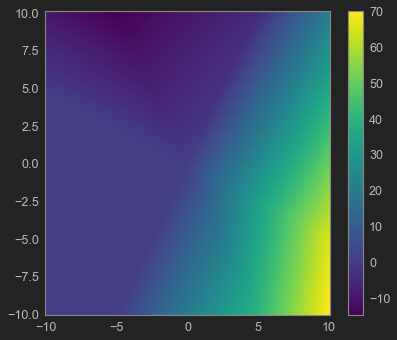

In [11]:
plt.pcolormesh(X.T[0].reshape(101,101), X.T[1].reshape(101,101), y.reshape(101,101), shading='auto')
plt.colorbar()

In [5]:
# Define a SoftWeightSharingDense with trainable loss function parameters
# Use self.add_loss to add soft weight sharing regularization.
# https://www.tensorflow.org/guide/keras/custom_layers_and_models

class SoftWeightSharingDense(keras.layers.Layer):
    def __init__(self, units, classes=3):
        super().__init__()
        self.units = units
        self.classes = classes

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.eta = self.add_weight(
            shape=(self.classes,),
            initializer="zeros",
            trainable=True,
        )
        self.mu = self.add_weight(
            shape=(self.classes,),
            initializer="random_normal",
            trainable=True,
        )
        self.ln_sigma = self.add_weight(
            shape=(self.classes,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        likelihood = tf.map_fn(self.calc_likelihood, self.w)
        losses = tf.map_fn(lambda x: -tf.math.log(x), likelihood)
        self.add_loss(tf.reduce_sum(losses))
        return keras.activations.relu(tf.matmul(inputs, self.w))

    def norm(self, x, loc, scale):
        n = 1 / tf.math.sqrt(2*math.pi*scale)
        n = n * tf.math.exp(-tf.square(x-loc) / (2*scale))
        return n
    
    def calc_likelihood(self, w):
        pi = tf.math.exp(self.eta) / tf.math.reduce_sum(tf.math.exp(self.eta))
        sigma = tf.math.exp(self.ln_sigma)
        norm = self.norm(x=w, loc=self.mu, scale=sigma)
        return tf.reduce_sum(tf.math.multiply(pi, norm))

In [6]:
tf.random.set_seed(0)

inputs = keras.Input(shape=(2,))
hidden = SoftWeightSharingDense(units=3)(inputs)
outputs = layers.Dense(1, use_bias=False)(hidden)
model_sws = keras.Model(inputs=inputs, outputs=outputs)

model_sws.compile(optimizer='rmsprop', loss="mse")

In [7]:
print(model_sws.layers[1].w)
print(model_sws.layers[1].eta)
print(model_sws.layers[1].mu)
print(model_sws.layers[1].ln_sigma)

<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.07555313,  0.0211461 , -0.02098475],
       [-0.05180186, -0.06184139,  0.02351365]], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.05334401,  0.00972746, -0.02654145], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>


In [8]:
model_sws.fit(X, y, epochs=100)

Epoch 1/100
319/319 [==============================] - 1s 3ms/step - loss: 446.7528
Epoch 2/100
319/319 [==============================] - 1s 4ms/step - loss: 359.3122
Epoch 3/100
319/319 [==============================] - 1s 3ms/step - loss: 258.7332
Epoch 4/100
319/319 [==============================] - 1s 3ms/step - loss: 156.3553
Epoch 5/100
319/319 [==============================] - 1s 3ms/step - loss: 74.6108
Epoch 6/100
319/319 [==============================] - 1s 4ms/step - loss: 23.2056
Epoch 7/100
319/319 [==============================] - 1s 4ms/step - loss: 4.1301
Epoch 8/100
319/319 [==============================] - 1s 3ms/step - loss: 1.9085
Epoch 9/100
319/319 [==============================] - 1s 3ms/step - loss: 1.4980
Epoch 10/100
319/319 [==============================] - 1s 3ms/step - loss: 1.1638
Epoch 11/100
319/319 [==============================] - 1s 3ms/step - loss: 0.8238
Epoch 12/100
319/319 [==============================] - 1s 3ms/step - loss: 0.4697
Epo

319/319 [==============================] - 1s 3ms/step - loss: -9.2967
Epoch 99/100
319/319 [==============================] - 1s 3ms/step - loss: -9.3144
Epoch 100/100
319/319 [==============================] - 1s 3ms/step - loss: -9.3299


In [9]:
print(model_sws.layers[1].w)
print(model_sws.layers[1].eta)
print(model_sws.layers[1].mu)
print(model_sws.layers[1].ln_sigma)

<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.03527641,  1.9788415 ,  0.30599687],
       [ 0.03528836, -0.743268  ,  1.1061686 ]], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([  8.559981, -11.275358, -11.24028 ], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.0362157, -0.7411822,  0.3100754], dtype=float32)>
<tf.Variable 'soft_weight_sharing_dense/Variable:0' shape=(3,) dtype=float32, numpy=array([-13.81516  ,  -6.332167 ,  -7.8367343], dtype=float32)>


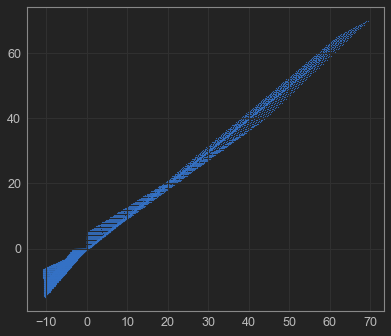

In [10]:
plt.scatter(model_sws.predict(X), y, s=1)